# Analisis de Datos - StackOverflow

El objetivo de este notebook es compartir el analisis del datasets StackOverflow, utilizando MapReduce para lograr los siguientes resultados:

1. Top 10 fechas con mayor cantidad de post creados
2. Relación entre cantidad de respuestas y sus visitas
3. Del ranking de los primeros 0-100 por score, tomar el tiempo de respuesta promedio e informar un único valor.

### Importación de las librerías necesarias

In [15]:
import xml.etree.ElementTree as ET
import csv
from datetime import datetime, timedelta
from typing import Counter
from functools import reduce

from lib.chunckify import chunckify

### Origen de Datos

In [16]:
tree = ET.parse(r"dataset/Stack Overflow 11-2010/112010 Meta Stack Overflow/posts.xml")
root = tree.getroot()

## 1. Top 10 fechas con mayor cantidad de post creados

Se toma el dato fecha del atributo ***CreationDate*** donde el formato es "*2008-09-06T08:07:10.730*". Para poder agrupar la cantidad de post, se ignora la parte correspondiente a la hora. Además se considera solo la fecha de creación del post original (tipo question). 

In [17]:
def get_creationdate(data):
    ''' Devuelve la fecha en formato yyyy-mm-dd
        param: row object
        return: str|None
    '''
    if data.attrib["PostTypeId"] == '1':
        return data.attrib["CreationDate"].split("T")[0]

In [18]:
def mapped_count_post_for_date(data):
    ''' Retorna un contador con la cantidad de ocurrencias de cada fecha
        param: list<row object>
        return: Counter
    '''
    creationdate_all = list(map(get_creationdate, data))
    creationdate = list(filter(None, creationdate_all))
    return Counter(creationdate)

In [19]:
def update_counters(data1, data2):
    ''' Retorna un contador con sus elementos de los parametros actualizados 
        param: Counter, Counter
        return: Counter
    '''
    data1.update(data2)
    return data1

In [22]:
data_chunks = chunckify(root, 50)

data_mapped = list(map(mapped_count_post_for_date, data_chunks))
data_filter = list(filter(None, data_mapped))
data_reduced = reduce(update_counters, data_filter)

top_10_date = data_reduced.most_common(10)

with open("output/top_10_count_post_by_date.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Date', 'Count'])
    writer.writerows(top_10_date)

print("Fechas con mayor cantidad de posteos")
for row in top_10_date:
    print(row)

Fechas con mayor cantidad de posteos
('2009-06-30', 93)
('2009-07-16', 86)
('2009-06-28', 84)
('2009-06-29', 82)
('2009-07-15', 80)
('2009-07-09', 76)
('2009-07-06', 74)
('2009-07-02', 71)
('2009-07-20', 71)
('2009-07-23', 71)


## 2. Relación entre cantidad de respuestas y sus visitas

Se toma el dato de los atributos ***ViewCount*** y ***AnswerCount***. Estos dos datos son numéricos pero no exactamente el mismo rango de valores. Para conocer la relación entre estos dos datos, se podría calcular de Coeficiente de Correlación de Pearson aplicando la siguiente formula
$$r=\frac{\sum (x-m_x)(y-m_y)}{\sum (x-m_x)^2 \sum (x-m_y)^2}$$
donde $m_x$ es la media de los valores de $x$ y $m_y$ es la media de los valores de $y$.
Para el cálculo de $r$, aplicando MapReduce, se necesitó recorrer dos veces el conjunto de dato. Primero se calculan las medias de los dos valores cantidad de vistas y cantidad de respuestas; y por último para el calculo de las sumatorias.

**Aclaración:** para que el valor que se obtiene de $r$ sea válido, se necesita checkear que los valores de cantidad de vistas y cantidad de respuestas tengan una distribución normal. Además calcular el valor de confianza (p-value) de ese resultado.

#### Parte uno. Cálculo de media de cantidad de vistas y cantidad de respuestas

In [23]:
def get_answer_and_viewcount(data):
    ''' Retorna el dato de cantidad de vista y de cantidad de respuestas
        param: row object
        return: None|<str, str>
    '''
    try:
        view = data.attrib["ViewCount"]
        answer = data.attrib["AnswerCount"]

        return view, answer
    except:
        return None

In [24]:
def mapped_list_data(data):
    ''' Retorna una lista de tuplas (cantidad de vistas, cantidad de respuestas)
        param: list(<row object>)
        return: list((str,str))
    '''
    list_data = list(map(get_answer_and_viewcount, data))
    filter_data = list(filter(None, list_data))
    return filter_data

In [25]:
def mapped_sum_view_answer(data):
    ''' Retorna la suma de la cantidad de vistas, la cantidad de respuestas y la cantidad de datos sumados
        param: list((str,str))
        return list(int, int, int)
    '''
    view = 0
    answer = 0
    count_data = 0

    for item in data:
        view += int(item[0])
        answer += int(item[1])
        count_data += 1
    
    return [view, answer, count_data]

In [26]:
def sum_reduce(data1, data2):
    ''' Retorna la suma de cada elemento de las listas como parametro
        param: list(int, int, int), list(int, int, int)
        return: list(int, int, int)
    '''
    return [data1[0] + data2[0], data1[1] + data2[1], data1[2] + data2[2]]

In [28]:
data_chunks = chunckify(root, 50)

data_mapped = list(map(mapped_list_data, data_chunks))
data_reduce = list(map(mapped_sum_view_answer, data_mapped))
sum_data = reduce(sum_reduce, data_reduce)

view_mean = sum_data[0] / sum_data[2]
answer_mean = sum_data[1] / sum_data[2]

print("Media de Cantidad de Vistas: ", view_mean)
print("Media de Cantidad de Respuesta: ", answer_mean)

Media de Cantidad de Vistas:  169.77599311630576
Media de Cantidad de Respuesta:  2.9624265022228595


In [29]:
# Se guardan los datos seleccionados, para futuros analisis
with open("output/relation_between_view_and_answer_data.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ViewCount', "AnswerCount"])
    for chunk in data_mapped:
        for row in chunk:
            writer.writerow(row)

#### Parte dos. Cálculo de las sumatorias
En este recorrido de los datos se va a calcular las expresiones 
- $\sum (x-m_x)(y-m_y)$
- $\sum (x-m_x)^2$
- $\sum (y-m_y)^2$

In [46]:
def mapped_sum_expressions(data, means):
    ''' Retorna una lista con las tres sumatorias
        param: list((str, str)), list((int, int))
        return: list(int, int, int)
    '''
    sum1 = 0
    sum2 = 0
    sum3 = 0
    
    for item in data:
        diff_view = int(item[0]) - means[0]
        diff_answer = int(item[1]) - means[1]

        sum1 += diff_view * diff_answer
        sum2 += diff_view * diff_view
        sum3 += diff_answer * diff_answer
    
    return [sum1, sum2, sum3]

In [47]:
data_chunks = chunckify(root, 50)

mean_list = [(view_mean, answer_mean) for i in range(len(data_mapped))]

data_process = list(map(mapped_sum_expressions, data_mapped, mean_list))
sums = reduce(sum_reduce, data_process)

num = sums[0]
den = (sums[1] * sums[2]) ** 0.5

r = num / den

with open("output/relation_between_view_and_answer.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Correlation'])
    writer.writerow([r])

print("Correlación entre cantidad de vistas y cantidad de respuestas: ", r)

Correlación entre cantidad de vistas y cantidad de respuestas:  0.4875917971953677


#### Parte Adicional. Grafico de Relación entre Cantidad de Vistas y Cantidad de Respuestas

Se toman los datos de cada (cantidad de vista, cantidad de respuesta) para que se pueda visualizar gráficamente si el dato obtenido se relacionan con su gráfica 

In [30]:
import pandas as pd
import seaborn as sns

In [31]:
dataset_view_answer = pd.read_csv("output/relation_between_view_and_answer_data.csv")
print(dataset_view_answer.head())

   ViewCount  AnswerCount
0       1836           13
1        249            4
2        154            4
3        351            9
4         85            2


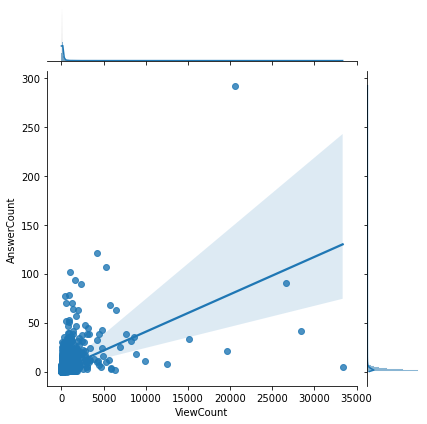

In [32]:
g = sns.jointplot(x="ViewCount", y="AnswerCount", data=dataset_view_answer, kind="reg")

<AxesSubplot:xlabel='ViewCount', ylabel='Count'>

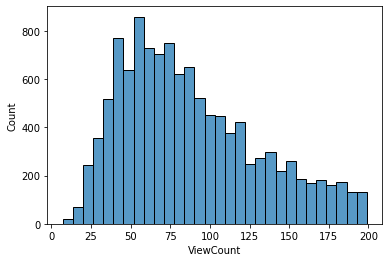

In [54]:
sns.histplot(data=dataset_view_answer[dataset_view_answer["ViewCount"] < 200], x="ViewCount", bins=30)

<AxesSubplot:xlabel='AnswerCount', ylabel='Count'>

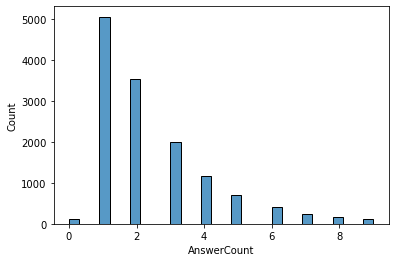

In [51]:
sns.histplot(data=dataset_view_answer[dataset_view_answer["AnswerCount"] < 10], x="AnswerCount", bins=30)

In [43]:
from scipy.stats import pearsonr

In [44]:
without_tail = dataset_view_answer[dataset_view_answer]
x = dataset_view_answer["ViewCount"]
y = dataset_view_answer["AnswerCount"]

In [63]:
print("Coeficiente de Correlación Pearson: ", pearsonr(x, y))
print("Coeficiente de Correlación Pearson para los primeros 1000 datos: ", pearsonr(x[:1000], y[:1000]))


Coeficiente de Correlación Pearson:  (0.4875917971953668, 0.0)
Coeficiente de Correlación Pearson para los primeros 1000 datos:  (0.4443087551777952, 1.244911632305328e-49)


Como conclusión de esta parte, aplicando la técnica de MapReduce se pudo realizar un cálculo complejo sobre gran volumen de datos sin estresar los recursos computacionales. Adicionalmente, se mostró que el resultado  $r$ arrojado no sería del todo válido por haber sido aplicado sobre datos que no tienen una distribución normal (ver en los gráficos). 

## 3. Del ranking de los primeros 0-100 por score, tomar el tiempo de respuesta promedio e informar un único valo

En este caso se utilizan los datos ***CreationDate*** y ***Score***. Para calcular el tiempo de respuesta se realizó la diferencia entre la fecha de creación de la respuesta y la fecha de creación de la pregunta. Estos datos no estan en una misma fila así que se necesitó agrupar los datos por el ***Id*** o ***ParentId*** segun el caso. Durante el proceso se fue descartando aquellas respuestas que no estaban dentro de los 100 mejores por puntaje.

In [64]:
def get_columns_dates_score(data):
    ''' Returna un dict con el Id delo post y una lista con los datos de fechas de creación y puntaje
        param: row object
        return: dict(str: [str, None, None]|[None, str, str])
    '''
    if data.attrib["PostTypeId"] == '2':
        value = {"CreationPost": None,
                "CreationDate": data.attrib["CreationDate"],
                "Score": data.attrib["Score"]}
        
        return dict({data.attrib["ParentId"]: [value]})
    else:
        value = {"CreationPost": data.attrib["CreationDate"],
                "CreationDate": None,
                "Score": None}
        return dict({data.attrib["Id"]: [value]})

In [65]:
def groupby_id(data1, data2):
    """ Retorna un dict con los datos actualizados de los dos parametros. Actualiza los datos None dentro de la lista de valores
        param: dict(str:[str, str, str]), dict(str:[str, str, str])
        return: dict(str:[str, str, str])
    """
    for key, value in data2.items():
        if key in data1.keys():
            for i in value:
                i["CreationPost"] = data1[key][0]["CreationPost"]

            data1[key] = data1[key] + value
        else:
            data1.update({key: value})

    for value in data1.values():
        if len(value) > 1 and value[0]["CreationDate"] == None:
            value.remove(value[0])

    return data1

In [66]:
def mapped_groupby_id(data):
    ''' Retorna un dict con los datos agrupados por Id '''
    columns = list(map(get_columns_dates_score, data))
    data_groupped = reduce(groupby_id, columns)
    return data_groupped

In [67]:
def greatest_100(data1, data2):
    ''' Retorna un dict con los datos agrupados por id, 
        pero descartando los valores que no van a estar dentro de los 100 por puntaje
    '''
    data1_groupby = groupby_id(data1, data2)
    score_100 = []

    for value in data1_groupby.values():
        for i in value:
            if i["Score"] == None:
                continue
            score_100.append(int(i["Score"]))

    score_100 = sorted(score_100, reverse=True)

    if len(score_100) > 100:
        for value in data1_groupby.values():
            if len(value) == 1:
                continue

            delete_rows = []
            for i in value:
                if i["Score"] == None:
                    continue

                if int(i["Score"]) < score_100[99]:
                    delete_rows.append(i)
            
            if len(value) == len(delete_rows):
                delete_rows = delete_rows[1:]

            for d in delete_rows:
                value.remove(d)

    return data1_groupby

In [68]:
def prom_timeresp_most100(data):
    ''' Retorna el promedio de tiempo de respuesta de los 100 por puntaje '''
    score_100 = []

    for value in data.values():
        for i in value:
            if i["Score"] == None:
                continue
            score_100.append(int(i["Score"]))

    score_100 = sorted(score_100, reverse=True)

    list_data = []
    for value in data.values():
        for i in value:
            if i["Score"] != None and int(i["Score"]) >= score_100[99]:
                post = i["CreationPost"] 
                resp = i["CreationDate"]
                if post != None and resp != None:
                    post_date = datetime.strptime(post[:-4], "%Y-%m-%dT%H:%M:%S")
                    resp_date = datetime.strptime(resp[:-4], "%Y-%m-%dT%H:%M:%S")
                    list_data.append(resp_date - post_date)
    
    sum_days = timedelta(days=0)
    len_data = len(list_data)
    for element in list_data:
        sum_days += element
    
    if len_data > 0:
        return sum_days.days / len_data

In [70]:
data_chunks = chunckify(root, 50)

data_mapped = list(map(mapped_groupby_id, data_chunks))
data_reduced = reduce(greatest_100, data_mapped)
average_timeresp = prom_timeresp_most100(data_reduced)

with open("output/prom_timeresp_most100_by_score.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Average days'])
    writer.writerow([average_timeresp])

print("Promedio de tiempo de respuesta en días para los 100 score mas altos:", average_timeresp)

Promedio de tiempo de respuesta en días para los 100 score mas altos: 7.009708737864078
